# Prédiction de documents au sein d'un corpus

## Objectif principal : 

Trouver les motifs définissant une œuvre au sein d'un même corpus en tentant de sélectionner celles qui sont le plus distinctives d'une oeuvre dans notre corpus. On va mettre en place pour cela un modèle prédictif à partir duquel nous récupérerons les motifs ayant permis de réaliser cette prédiction. La problématique qui sous-tend cela est le choix des motifs les plus pertinents pour caractériser (prédire) une oeuvre plutôt qu'une autre au sein du corpus.

## Méthodologie :

Nous utilisons pour atteindre cet objectif une technique de classification linéaire multinomiale (> à deux classes à prédire) qui prend la forme suivante :
$$y_i = \alpha_1 X_{i1} + \alpha_2 X_{i2} + \ldots + \alpha_p X_{ip} = f_\alpha(X)$$
où $y$ indique le document $i$ et $X_i$ est un vecteur de caractéristiques (*features*) calculé à partir de motifs de longueur $p$ pour le document $i$.

La régression logistique multinomiale (ou modèle logit multinomial) est une généralisation de la régression logistique binaire qui permet de modéliser des variables dépendantes de nature catégorielle avec plus de deux modalités. Ce modèle est couramment utilisé en statistiques et en apprentissage automatique pour prédire des variables cibles

Au lieu d'adapter ce classificateur au niveau de l'oeuvre, nous divisons chaque oeuvre du corpus en fenêtres de longueur fixe qui représentent alors les documents $i \in \{1, \ldots, n\}$. Nous obtenons ainsi une forte hausse du nombre d'observations sur lesquelles le modèles va s'entraîner et ensuite être testé. 

Nous appliquons le pipeline afin d'obtenir les annotations de motifs (ou toute autre *feature*, si on le souhaitait...). Ensuite, nous calculons les $X_i$ qui sont définis comme les scores TFIDF de chaque motif dans chaque document du corpus, où un document représente une fenêtre de motifs, comme indiqué ci-dessus.

### Présélection des caractéristiques

Dans ce cas d'étude, $p$ est très grand ($>80K$), nous introduisons donc un critère de sélection des caractéristiques avant d'estimer les paramètres. Puisque nous savons qu'un token qui a un tfidf de 0 correspond à des tokens non-informatifs, nous proposons une solution simple basée sur la rareté de la caractéristique $X_{ :,j}$. Nous définissons le niveau de rareté comme la proportion de 0 dans un vecteur : $\forall j, \operatorname{S}_j = 1/n\sum_i \operatorname{I}\{X_{i,j} = 0\}$. Plus le token est épars (*sparse*) dans le corpus, moins il est informatif, puisqu'il est plus commun à tous les documents. Ensuite, nous sélectionnons simplement les $P$ caractéristiques les moins éparses.

### Estimation

Pour ajuster le modèle, nous minimisons l'erreur quadratique moyenne comme dans un cadre classique de régression logistique multinomiale. Cependant, afin de sélectionner les motifs les plus importants, nous appliquons la régularisation L1 qui force les caractéristiques non informatives à avoir un coefficient de 0.

> La régularisation L1 (également appelée Lasso pour "Least Absolute Shrinkage and Selection Operator") est une technique utilisée en apprentissage automatique et en statistiques pour prévenir le surapprentissage (overfitting) et améliorer la généralisation des modèles. Cette technique fonctionne en ajoutant une pénalité au terme de coût du modèle, ce qui permet de contrôler la complexité du modèle et d'encourager la parcimonie (ou sparsité) des coefficients.


### Évaluation

Pour évaluer le modèle, nous divisons les données en échantillons de formation et de test, où les observations de l'échantillon de test proviennent de documents qui ne font pas partie de l'échantillon de formation. Enfin, nous utilisons la métrique de précision sur l'ensemble de test.


## Import librairies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from motifs.pipeline import Pipeline
from motifs.features import build_tfidf
from motifs.utils import build_window_corpus, return_to_text_from_token

On commence, comme dans le premier cas d'étude, par récupérer notre corpus tokénisé et annoté pour le transformer en séquences de ngrams.

In [2]:
# Define the path of the corpus
# tokens_dir = None
tokens_dir="/Users/antoinedesacy/Documents/py-motifs-formation/damasio/20240929_100442_pipeline/tokens/"
corpus_dir = None
# Define the token type: AVAILABLE_TOKEN_TYPES = ["text", "lemma", "pos", "motif"]
token_type = "motif"
# n-gram length
n = 5

pipeline = Pipeline(token_type, corpus_dir=corpus_dir, tokens_dir=tokens_dir, save=False)
pipeline.transform_to_ngrams(n)
ngrams = pipeline.ngrams
ngrams.head()

[PyMotifs-Logger:pipeline.py:96] - [6338] - 2024-10-02 22:14:09 - DEBUG - Loading tokens from directory: /Users/antoinedesacy/Documents/py-motifs-formation/damasio/20240929_100442_pipeline/tokens/...
[PyMotifs-Logger:pipeline.py:99] - [6338] - 2024-10-02 22:14:09 - DEBUG - Done in 0.47 secs.
[PyMotifs-Logger:features.py:49] - [6805] - 2024-10-02 22:14:15 - DEBUG - Steps to go 20
[PyMotifs-Logger:features.py:49] - [6806] - 2024-10-02 22:14:15 - DEBUG - Steps to go 19
[PyMotifs-Logger:features.py:49] - [6804] - 2024-10-02 22:14:15 - DEBUG - Steps to go 18
[PyMotifs-Logger:features.py:49] - [6807] - 2024-10-02 22:14:15 - DEBUG - Steps to go 17
[PyMotifs-Logger:features.py:49] - [6811] - 2024-10-02 22:14:15 - DEBUG - Steps to go 15
[PyMotifs-Logger:features.py:49] - [6815] - 2024-10-02 22:14:15 - DEBUG - Steps to go 13
[PyMotifs-Logger:features.py:49] - [6809] - 2024-10-02 22:14:15 - DEBUG - Steps to go 16
[PyMotifs-Logger:features.py:49] - [6812] - 2024-10-02 22:14:15 - DEBUG - Steps to g

word                                text                     token  \
0       Le             Le silence qui suit est       le NC qui PRES être   
1  silence     silence qui suit est proprement   NC qui PRES être ADVMAN   
2      qui  qui suit est proprement golgothien  qui PRES être ADVMAN ADJ   
3     suit    suit est proprement golgothien :    PRES être ADVMAN ADJ :   
4      est    est proprement golgothien : brut     être ADVMAN ADJ : ADJ   

         doc  
0  Callirhoe  
1  Callirhoe  
2  Callirhoe  
3  Callirhoe  
4  Callirhoe

In [3]:
# Let's filter our corpus based on our previous analysis : 
ngrams = pipeline.ngrams[pipeline.ngrams['doc'].isin(['Sov_Strochnis', 'Pietro', 'Oroshi', 'Golgoth', 'Aoi_Nan', 'Larco_Scarsa', 'Caracole'])]
ngrams

word                            text                 token  \
2384          J'       J' attends la réaction de      je PRES le NC de   
2385     attends  attends la réaction de Golgoth   PRES le NC de PROPN   
2386          la        la réaction de Golgoth .      le NC de PROPN .   
2387    réaction        réaction de Golgoth . Il      NC de PROPN . il   
2388          de              de Golgoth . Il n'     de PROPN . il ADV   
...          ...                             ...                   ...   
169014     tiens         tiens : Respire sans en     ADJ : ADV sans en   
169015         :         : Respire sans en avoir   : ADV sans en avoir   
169016   Respire        Respire sans en avoir l'  ADV sans en avoir le   
169017      sans            sans en avoir l' air   sans en avoir le NC   
169018        en             en avoir l' air ...    en avoir le NC ...   

             doc  
2384      Pietro  
2385      Pietro  
2386      Pietro  
2387      Pietro  
2388      Pietro  
...          ...  
169014  Caracole  
169015  Caracole  
169016  Caracole  
169017  Caracole  
169018  Caracole  

[154149 rows x 4 columns]

## Build window of fixed length from the data

Comme dit précédemment, nous divisons chaque oeuvre du corpus en fenêtres de longueur fixe afin d'obtenir une forte hausse du nombre d'observations sur lesquelles le modèles va s'entraîner et ensuite être testé. Nous choisissons ici des fenêtres de longueur de 500 mots. 

In [4]:
seq_length = 500
data = build_window_corpus(ngrams, seq_length)
# Create class mapper
class_mapper = {d: i for i, d in enumerate(data["doc"].unique())}
data["class"] = [class_mapper[data["doc"][i]] for i in range(len(data))]
data["doc"] = data["doc"] + "_w_" + data["window"].astype(str)
doc = data.doc.unique().tolist()
data.head()

window                            text                token         doc  \
0       0       J' attends la réaction de     je PRES le NC de  Pietro_w_0   
1       0  attends la réaction de Golgoth  PRES le NC de PROPN  Pietro_w_0   
2       0        la réaction de Golgoth .     le NC de PROPN .  Pietro_w_0   
3       0        réaction de Golgoth . Il     NC de PROPN . il  Pietro_w_0   
4       0              de Golgoth . Il n'    de PROPN . il ADV  Pietro_w_0   

   class  
0      0  
1      0  
2      0  
3      0  
4      0

In [5]:
doc

['Pietro_w_0',
 'Pietro_w_500',
 'Pietro_w_1000',
 'Pietro_w_1500',
 'Pietro_w_2000',
 'Pietro_w_2500',
 'Pietro_w_3000',
 'Pietro_w_3500',
 'Pietro_w_4000',
 'Pietro_w_4500',
 'Pietro_w_5000',
 'Pietro_w_5500',
 'Pietro_w_6000',
 'Pietro_w_6500',
 'Pietro_w_7000',
 'Pietro_w_7500',
 'Pietro_w_8000',
 'Pietro_w_8500',
 'Pietro_w_9000',
 'Pietro_w_9500',
 'Pietro_w_10000',
 'Pietro_w_10500',
 'Pietro_w_11000',
 'Pietro_w_11500',
 'Pietro_w_12000',
 'Pietro_w_12500',
 'Pietro_w_13000',
 'Pietro_w_13500',
 'Pietro_w_14000',
 'Pietro_w_14500',
 'Pietro_w_15000',
 'Pietro_w_15500',
 'Pietro_w_16000',
 'Pietro_w_16500',
 'Pietro_w_17000',
 'Pietro_w_17500',
 'Pietro_w_18000',
 'Pietro_w_18500',
 'Pietro_w_19000',
 'Pietro_w_19500',
 'Pietro_w_20000',
 'Pietro_w_20500',
 'Pietro_w_21000',
 'Pietro_w_21500',
 'Pietro_w_22000',
 'Pietro_w_22500',
 'Pietro_w_23000',
 'Pietro_w_23500',
 'Pietro_w_24000',
 'Pietro_w_24500',
 'Pietro_w_25000',
 'Pietro_w_25500',
 'Pietro_w_26000',
 'Pietro_w_26500'

## Class distribution

On peut commencer par analyser les différentiels de volume entre ces différentes fenêtres pour avoir une vision globale du déséquilibre de nos classes.

<Axes: xlabel='class', ylabel='proportion'>

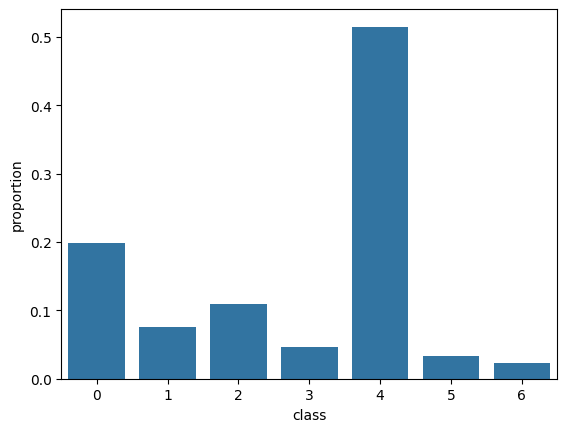

In [6]:
windows = data[["doc", "class"]].drop_duplicates(keep="first")
sns.countplot(windows, x="class", stat="proportion")

## Train/test split

La division des données en ensembles d'entraînement (train set) et de test (test set) est une étape cruciale dans le cadre de l'apprentissage supervisé. Cela permet d'évaluer la performance du modèle et de vérifier sa capacité à généraliser à des données non observées (ou inconnues).

Pourquoi diviser les données en ensembles d’entraînement et de test ? 

La division des données en deux ensembles distincts a pour but de :

- Entraîner le modèle sur une partie des données (appelée train set) pour ajuster les paramètres (comme les coefficients dans une régression logistique).
- Tester la performance du modèle sur des données qu'il n'a jamais vues (appelée test set). Cela permet d'évaluer comment le modèle se généralise à de nouvelles données et d’éviter le sur-apprentissage (overfitting).

In [7]:
test_size = 0.3
random_state = 0 # For reproducibility
np.random.seed(random_state)
# Use StratifiedShuffleSplit to keep class balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
train_idx, test_idx = list(sss.split(windows["doc"], windows["class"]))[0]

train_data = data[data["doc"].isin(windows.iloc[train_idx]["doc"])]
test_data = data[data["doc"].isin(windows.iloc[test_idx]["doc"])]

Le déséquilibre observé nous incite à procéder à une régularisation afin de ne pas déséquilibrer le modèle et l'influencer à prédire la classe la plus dominante. Pour cela, nous utilisons un procédé appelé le StratifiedShuffleSplit de la bibliothèque *scikit-learn*, spécifiquement conçue pour gérer des données avec des étiquettes déséquilibrées. 

Le StratifiedShuffleSplit garantit que la proportion de chaque classe dans les données est maintenue dans chaque ensemble d'entraînement et de test.

## Featurization (TFIDF)

Notre régression logisitique utilisera les scores de Tf-IDF sur les motifs afin de procéder à la prédiction de chacun des segments (fenêtres) à chacune des classes (chaque oeuvre du corpus). 

In [8]:
## Train set

t1 = time.time()
train_tfidf, model, dictionary = build_tfidf(train_data, normalize=False, smartirs="nfn")
t2 = time.time()
print(f"{t2-t1:.2f}")

# Test set
t1 = time.time()
test_tfidf, _, _ = build_tfidf(test_data, model=model, dictionary=dictionary, normalize=False, smartirs="nfn") # Use train_idf
t2 = time.time()
print(f"{t2-t1:.2f}")

4.86
2.20


In [9]:
# Transform to a table with documents as indices and tokens as columns
t1 = time.time()
train_tfidf = train_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")
t1 = time.time()
test_tfidf = test_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")

(train_tfidf.shape, test_tfidf.shape)

8.42
4.65


((212, 81102), (91, 110759))

Certains tokens apparaissent dans le jeu d'entraînement qui ne sont pas dans le jeu de test, nous les ramenons à 0 quoi qu'il arrive pour équilibrer les observations entre les deux jeux.

In [10]:
# Remove new tokens and add missing ones in the test set
if set(train_tfidf.columns) != set(test_tfidf.columns):
    missing_features_in_test = pd.DataFrame(0, columns=list(set(train_tfidf.columns) - set(test_tfidf.columns)), index=test_tfidf.index)
    test_tfidf = pd.concat([test_tfidf, missing_features_in_test], axis=1)
    test_tfidf = test_tfidf[train_tfidf.columns]
    
    missing_features_in_train = list(set(test_tfidf.columns) - set(train_tfidf.columns))
    if len(missing_features_in_train):
        # Remove new features in test set (they are equal to 0 anyway)
        test_tfidf.drop(missing_features_in_train, axis=1, inplace=True)
(train_tfidf.shape, test_tfidf.shape)

((212, 81102), (91, 81102))

In [11]:
# Shuffle the train set
indices = list(range(len(train_tfidf)))
np.random.shuffle(indices)
train_tfidf = train_tfidf.iloc[indices]

### 80k features (motifs), c'est trop !!

Nous devons introduire un critère de sélection des caractéristiques. Puisque nous savons qu'un token qui a un tfidf de 0 correspond à des tokens non informatifs, nous proposons une solution simple basée sur la sparsité de chaque colonne de la matrice `train_features`. Cf. Section Pré-sélection des caractéristiques : "Plus le token est épars (*sparse*) dans le corpus, moins il est informatif, puisqu'il est plus commun à tous les documents. Ensuite, nous sélectionnons simplement les $P$ caractéristiques les moins éparses".

Nous définissons le niveau de rareté comme la proportion de 0 dans une colonne d'une matrice ($\forall j, \operatorname{S}_j = 1/n\sum_i \operatorname{I}\{M_{ij} = 0\}$ où $n$ est le nombre de lignes dans la matrice $M$ et $j$ représente un jeton en tant que colonne). Plus la colonne d'un mot-clé est clairsemée (*sparse*), moins le motif est informatif dans le corpus, puisqu'il est plus commun à tous les documents. Ensuite, nous appliquons simplement un seuil, par exemple $u = 0.8$, et sélectionnons $j$ si $\operatorname{S}_j \leq u$.

In [12]:
sparsity = np.sum(train_tfidf == 0, axis=0)/len(train_tfidf)
to_keep = sparsity.index[sparsity < 0.9]
train_tfidf = train_tfidf[to_keep]
test_tfidf = test_tfidf[to_keep]

## Normalization

Dernière étape, la normalisation. L'objectif du MinMaxScaler est de redimensionner les valeurs de chaque caractéristique (ou variable) d'un ensemble de données afin qu'elles se trouvent dans une plage définie, généralement entre 0 et 1. Cela est particulièrement utile lorsque les algorithmes de machine learning sont sensibles à l'échelle des données, comme les modèles basés sur des distances (par exemple, la régression logistique, les k-means, etc.).

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
train_features = scaler.fit_transform(train_tfidf)
test_features = scaler.transform(test_tfidf)

In [14]:
train_y = np.array([class_mapper[i.split("w")[0][:-1]] for i in train_tfidf.index])
test_y = np.array([class_mapper[i.split("w")[0][:-1]] for i in test_tfidf.index])

## Model

In [15]:
train_features.shape

(212, 90)

Comme nous avons encore beaucoup de caractéristiques (212), nous proposons d'utiliser une régularisation L1 pour sélectionner les caractéristiques les plus importantes. Elle introduit un hyperparamètre : C (la force de la pénalité).
Elle forcera de nombreux paramètres à être égaux à 0, ce qui introduit de la rareté dans la solution. Elle est donc plus facile à interpréter et nous donnera moins de motifs ayant servi *in fine* à la prédiction. 

/opt/anaconda3/envs/pymotifs-formation/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/pymotifs-formation/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train accuracy 69.81132075471697
Test accuracy 62.637362637362635
Sparisty 87.14285714285714


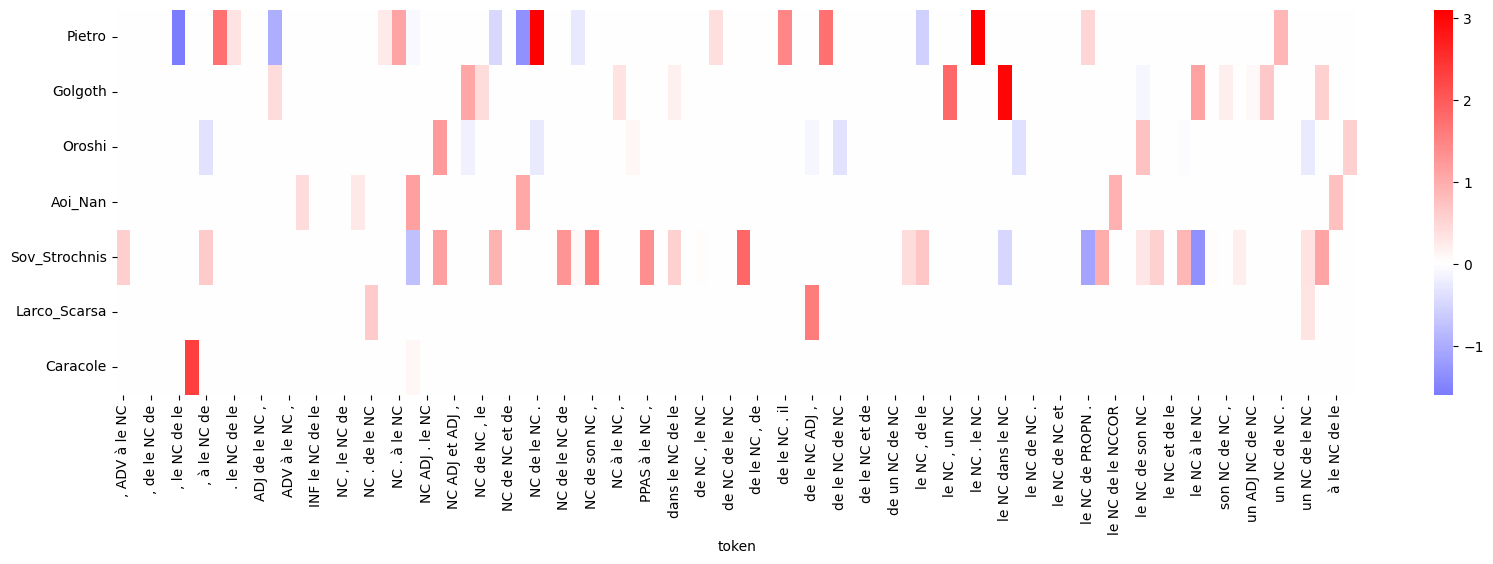

In [16]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class='multinomial', penalty='l1', solver='saga', C=0.99, random_state=random_state,
)
clf.fit(train_features, train_y)

print("Train accuracy", clf.score(train_features, train_y) * 100)
print("Test accuracy", clf.score(test_features, test_y) * 100)
print("Sparisty", np.mean(clf.coef_ == 0) * 100)

coefs = pd.DataFrame(clf.coef_, columns=train_tfidf.columns, index=class_mapper.keys())

plt.figure(figsize=(20,5))
sns.heatmap(coefs, cmap="bwr", center=0)
plt.show()

In [17]:
sum(coefs.loc['Golgoth',:] != 0)

13

Nous observons que seuls 13 tokens suffisent à prédire si un document appartient à « Golgoth ».

In [18]:
coefs.loc['Golgoth',:][coefs.loc['Golgoth',:] > 0].sort_values(ascending=False)

token
le NC dans le NC    3.005320
le NC , un NC       1.825102
le NC à le NC       1.133288
NC dans le NC ,     1.077819
un NC de NC ,       0.679230
à le NC , le        0.566844
ADV de le NC ,      0.438185
NC de NC , le       0.421465
NC à le NC ,        0.358950
son NC de NC ,      0.207560
dans le NC de le    0.192395
un ADJ NC de NC     0.088012
Name: Golgoth, dtype: float32

## Importance des caractéristiques (coefficients de régression)

Le graphique ci-dessous représente les coefficients de régression pour chaque document, qui peuvent être interprétés comme l'importance des caractéristiques.

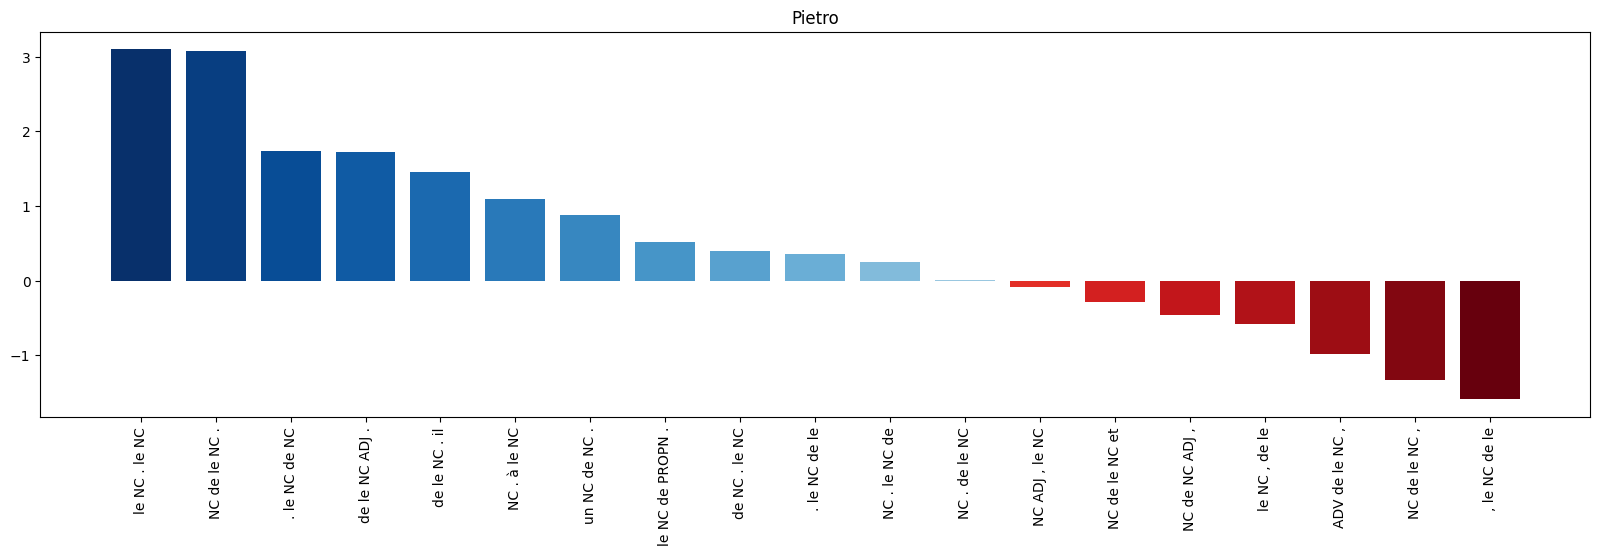

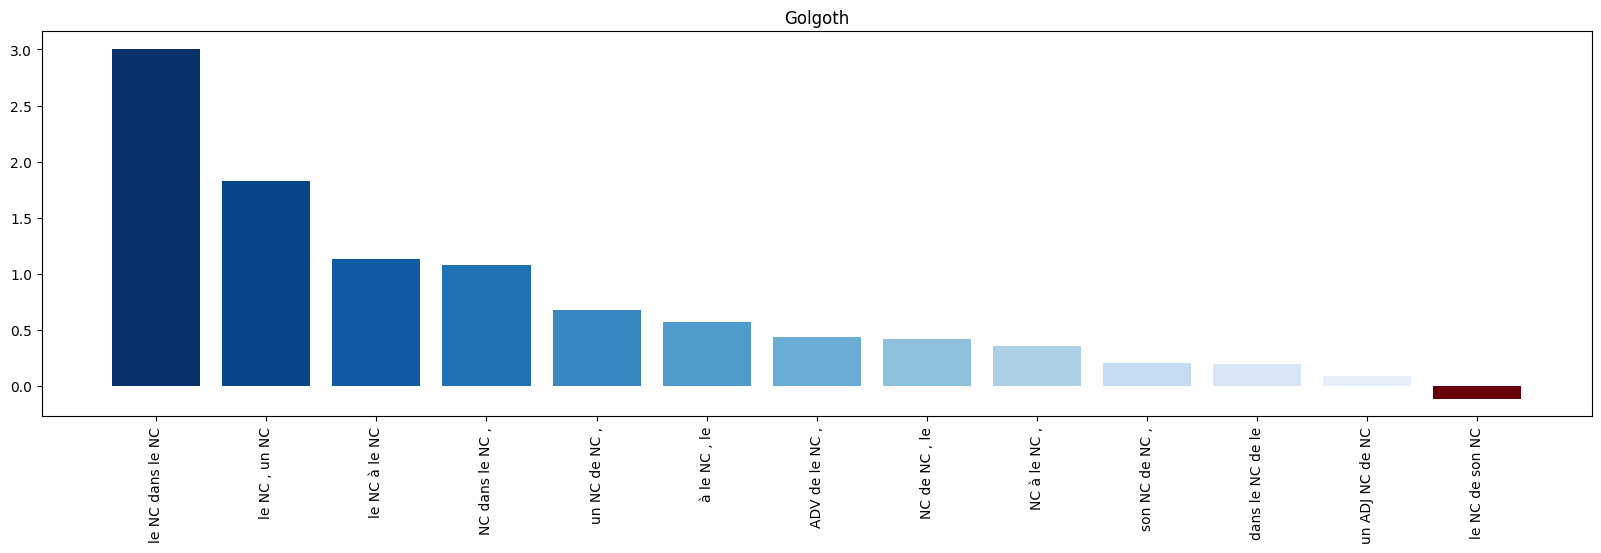

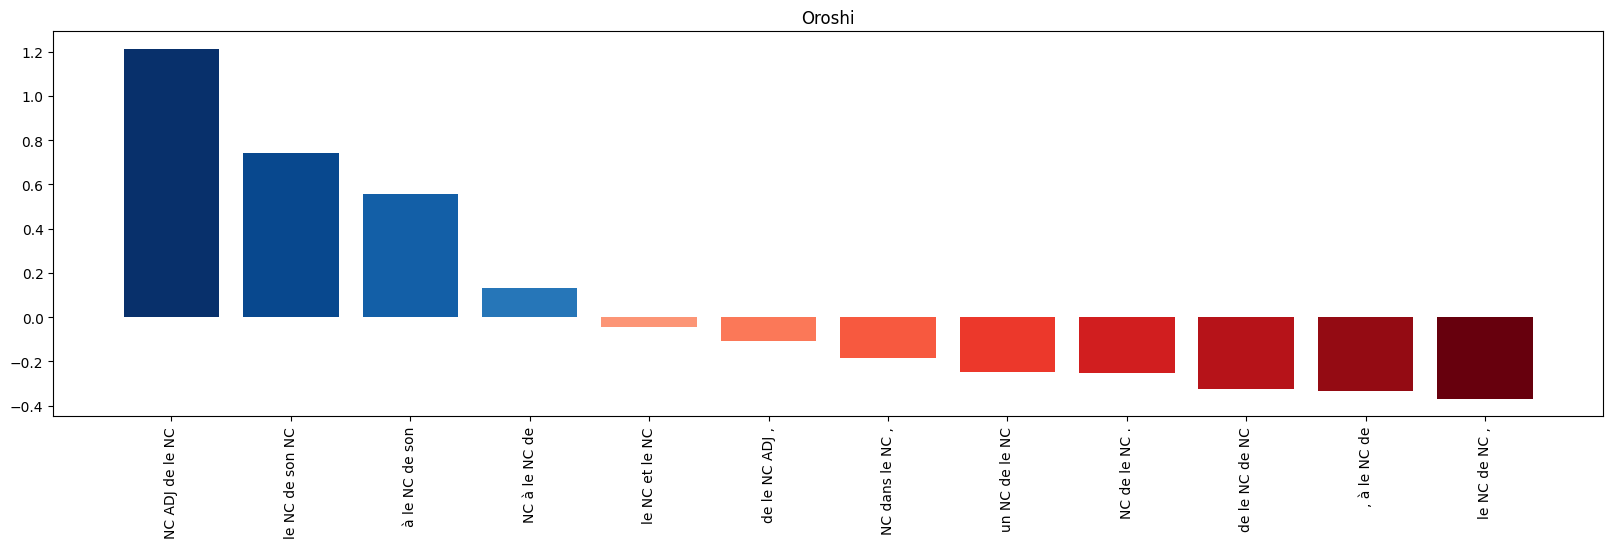

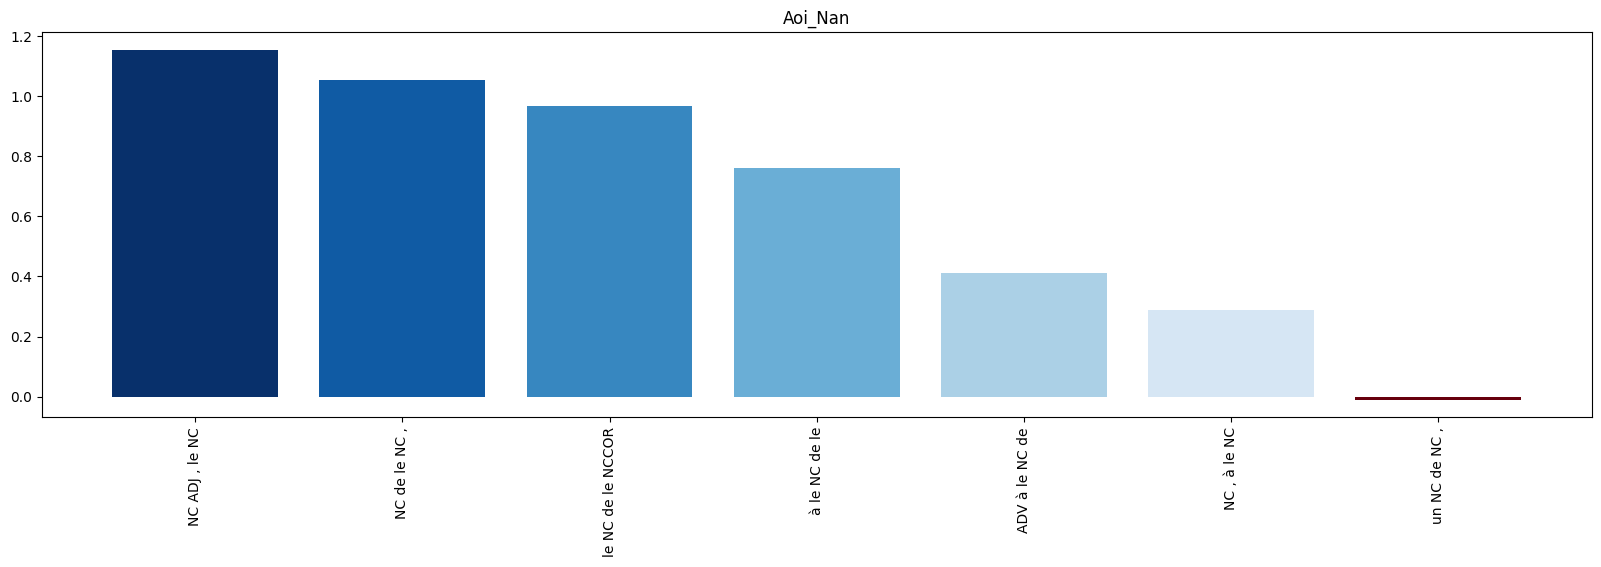

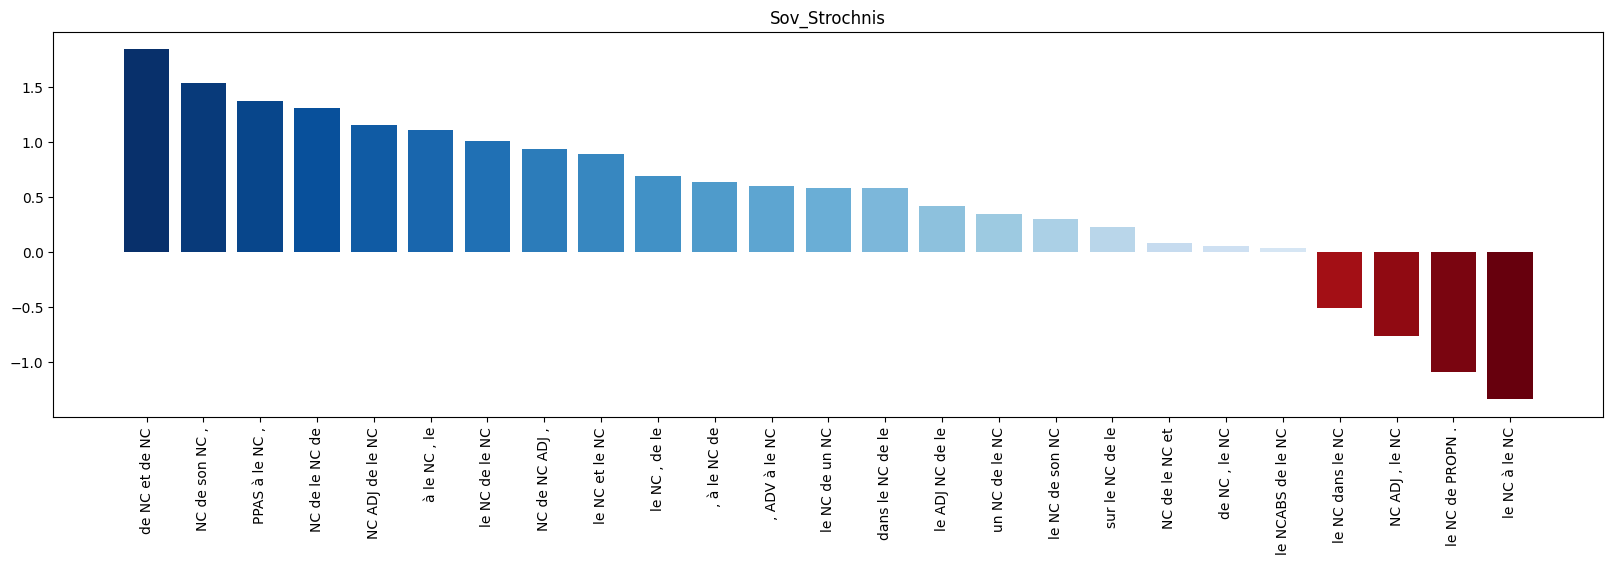

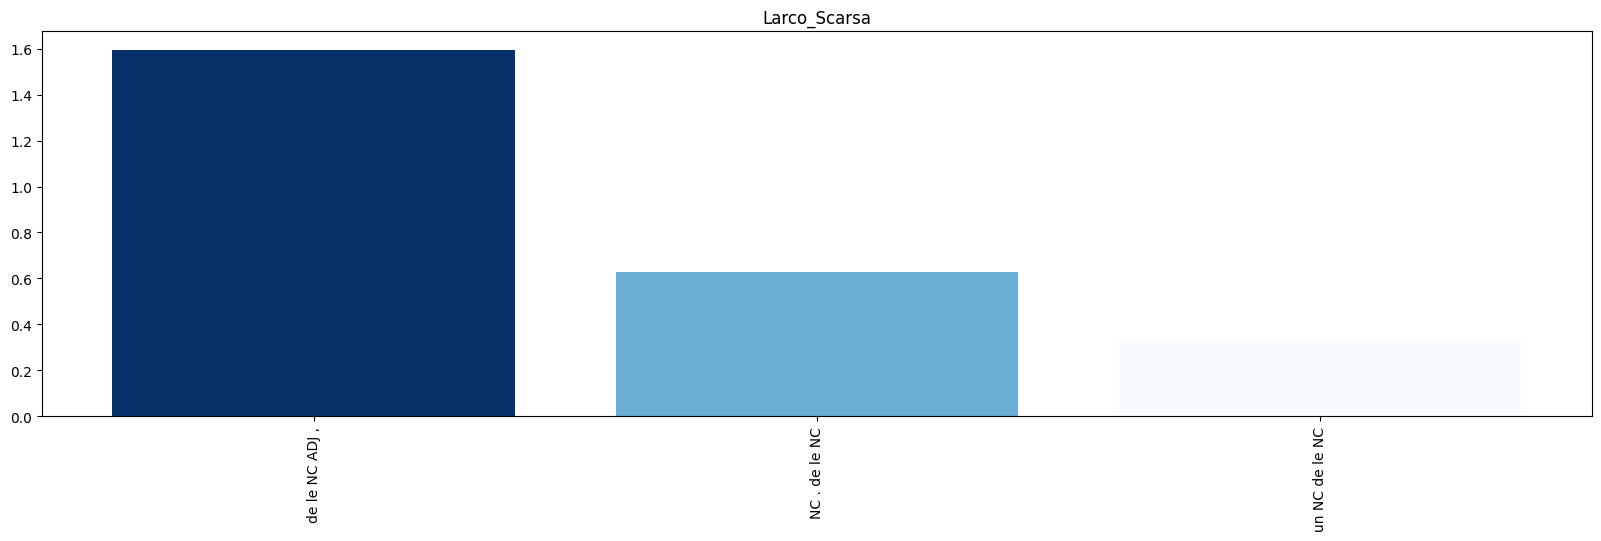

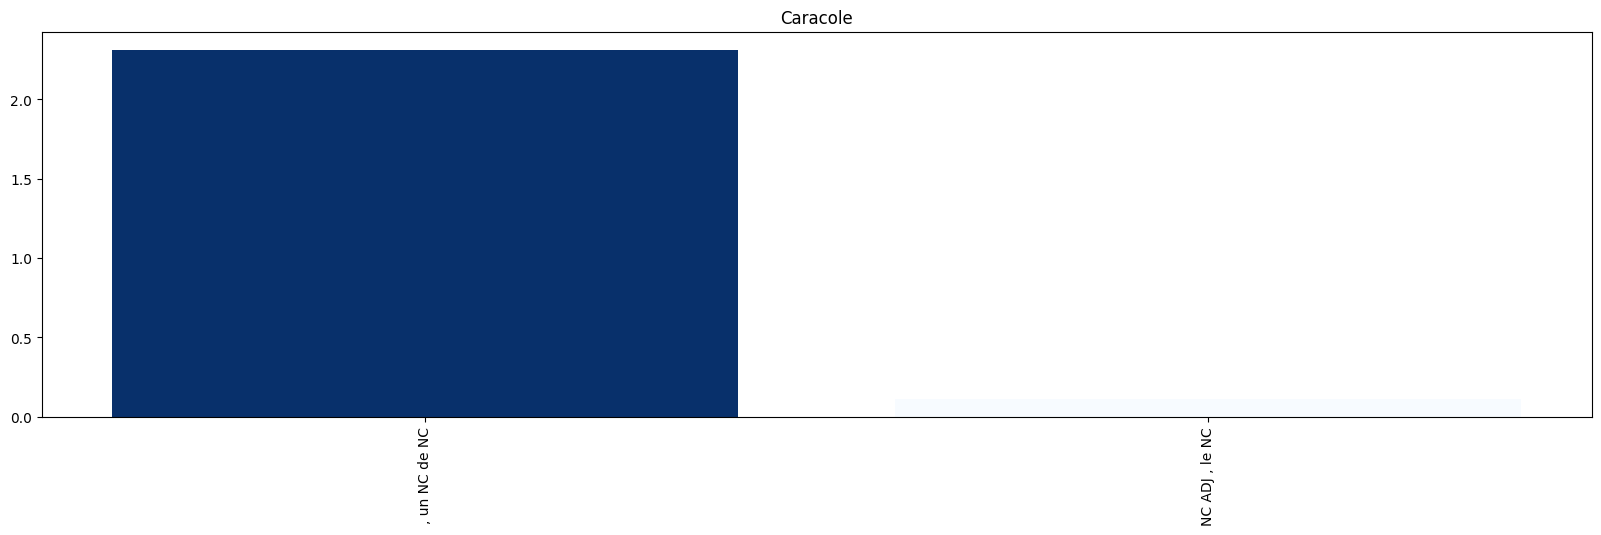

In [19]:
selected_features = {i: coefs.columns[coefs.loc[i] != 0].tolist() for i in coefs.index}
selected_features = {i: coefs.loc[i, f].sort_values(ascending=False) for i, f in selected_features.items()}

my_cmap = plt.get_cmap("bwr")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

for i in selected_features:
    
    values = selected_features[i]
    # Separate positive and negative values
    positive_values = [val if val > 0 else 0 for val in selected_features[i]]
    negative_values = [val if val < 0 else 0 for val in selected_features[i]]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20,5))

    # Plot positive values with varying shades of blue
    ax.bar(range(len(positive_values)), positive_values, color=plt.cm.Blues(np.linspace(0, 1, len(positive_values)))[::-1])

    # Plot negative values with varying shades of red
    ax.bar(range(len(negative_values)), negative_values, color=plt.cm.Reds(np.linspace(0, 1, len(negative_values))))

    # Customize the plot
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(selected_features[i].index, rotation=90)
    ax.set_title(i)
    plt.show()

In [20]:
most_important_motifs = coefs.idxmax(1)
doc = "Golgoth"
print(most_important_motifs[doc], coefs.loc[doc, most_important_motifs[doc]])

le NC dans le NC 3.00532


Le motif le plus important pour « Golgoth » est « le NC dans le NC » avec un coefficient de 3. Il a un impact très positif sur la probabilité qu'un texte soit identifié comme étant de la voix narrative du personnage de Golgoth.

## Return to text

In [26]:
doc = "Oroshi"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

left_context  \
0            site le plus précisément possible . À le   
1           de l' épreuve tenait toutefois moins à la   
2                  y réfléchir , Golgoth n' a qu' une   
3             ce serait plutôt Arval : lui possède un   
4           rare de ces esprits que leur puissance d'   
5            ! Les ærudits discutaient bien sûr de la   
6   étaient globalement d' accord pour y reconnaît...   
7   seulement pressentir à l' infime éraflure dans le   
8                     la trame – ou même pas : simple   
9                     a sorti son aile et il longe le   
10  les centaines d' années peut-être , les puissants   
11        puissants jets torsadés de les muscles , la   
12             . Absorbée par mes calculs , par cette   
13    Les oiseaux plongèrent aussitôt , attiré par la   
14         vifs concentrés dans dix mètres cubes , la   
15                 la flaque – ou même pas puisque la   

                                      text  \
0         faiblissement relatif de le flux   
1              vitesse linéaire de le flux   
2       science honnête de les écoulements   
3                contre proche de la magie   
4   enfantement préserve de le tarissement   
5           nature exacte de la révélation   
6         transcription visuelle de le vif   
7                lit compact de la vitesse   
8              décours local de la vitesse   
9               bord intérieur de la crête   
10            jets torsadés de les muscles   
11              tubulure fluante de les os   
12  rationalité rassurante de les chiffres   
13             voile rouge de le parapente   
14     structure aérologique de le cratère   
15       puissance fantasmatique de l' âme   

                                        right_context     doc            token  
0                    , je sais qu' il nous reste deux  Oroshi  NC ADJ de le NC  
1           qu' à les turbulences de sillage dans une  Oroshi  NC ADJ de le NC  
2             . Il manie les huit principaux types de  Oroshi  NC ADJ de le NC  
3              animale ) . C' est cette confiance qu'  Oroshi  NC ADJ de le NC  
4             et qui n' avaient besoin d' aucun autre  Oroshi  NC ADJ de le NC  
5   qu' offrait le véramorphe ; ils questionnaient la  Oroshi  NC ADJ de le NC  
6     , la valeur de cette transcription les divisait  Oroshi  NC ADJ de le NC  
7       , seulement poursuivre là où l' échancrure se  Oroshi  NC ADJ de le NC  
8   partout exubérante , simple passage de moindre...  Oroshi  NC ADJ de le NC  
9         , inspectant les parois et cherchant de les  Oroshi  NC ADJ de le NC  
10              , la tubulure fluante de les os bleus  Oroshi  NC ADJ de le NC  
11             bleus qui n' avaient à cet instant -là  Oroshi  NC ADJ de le NC  
12                 , j' avais fait une erreur ... Une  Oroshi  NC ADJ de le NC  
13                      d' Erg quand tout à coup , l'  Oroshi  NC ADJ de le NC  
14     se distordit brusquement , soit que le clonage  Oroshi  NC ADJ de le NC  
15   de Horst avait dû depuis longtemps déjà réformer  Oroshi  NC ADJ de le NC

Structure descriptive, intellectualisante, à mettre en relation avec la nature du personnage et son rôle.

In [21]:
context_len = 8
doc = "Golgoth"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

left_context  \
0               . Dans la ruelle , ça picorait à   
1        dedans , on finissait tous à croquer de   
2            babas de nous voir . Ils avaient de   
3               tout le monde à le même niveau ,   
4     brave ailier , fallait juste lui fondre de   
5                 d' Urle ! Un boyau de roc avec   
6        ses ailiers devant , ils ont clenché de   
7         , qu' on aurait dit qu' ils trouvaient   
8        jaune . Je sens mes chailles qui gluent   
9   sur nos quilles , les appuis marquaient avec   
10            , histoire de dire , et de prendre   
11        roustons , tu peux la hourder frérot ,   

                              text                             right_context  \
0            le bec dans les joues               . À y foutre les mains . J'   
1         le paveton dans la digue             . Moi en tête . Casque ou pas   
2   les étoiles dans les prunelles            . Ils se sont levés d' un bond   
3             le groin dans l' eau          , le baril derrière . C' est pas   
4            le plomb dans le plot  . Lui faire piger quelques trucs en aéro   
5      le rafalant dans la bouille         , sur trois bonnes bornes , et de   
6     le coinceur dans les failles    , ils ont chaîné comme pour un furvent   
7         l' ouverture dans le lit        de le vent , ça balançait comme de   
8         la salive dans le gosier            . J' ai les crocs à bouffer de   
9        les charges dans le pentu    et on s' appuyait sur le schnee pareil   
10        le rafalant dans la face     . Je suis resté à regarder l' horizon   
11        les crocs dans les roues                , à la mâchoire , yak ! tu   

        doc             token  
0   Golgoth  le NC dans le NC  
1   Golgoth  le NC dans le NC  
2   Golgoth  le NC dans le NC  
3   Golgoth  le NC dans le NC  
4   Golgoth  le NC dans le NC  
5   Golgoth  le NC dans le NC  
6   Golgoth  le NC dans le NC  
7   Golgoth  le NC dans le NC  
8   Golgoth  le NC dans le NC  
9   Golgoth  le NC dans le NC  
10  Golgoth  le NC dans le NC  
11  Golgoth  le NC dans le NC

Oralité, structure argotique construite sous forme COD + CC, située souvent en fin de phrase.

In [22]:
coefs.loc['Golgoth',:][coefs.loc['Golgoth',:] > 0].sort_values(ascending=False)

token
le NC dans le NC    3.005320
le NC , un NC       1.825102
le NC à le NC       1.133288
NC dans le NC ,     1.077819
un NC de NC ,       0.679230
à le NC , le        0.566844
ADV de le NC ,      0.438185
NC de NC , le       0.421465
NC à le NC ,        0.358950
son NC de NC ,      0.207560
dans le NC de le    0.192395
un ADJ NC de NC     0.088012
Name: Golgoth, dtype: float32

In [23]:
context_len = 8
doc = "Golgoth"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], 'un NC de NC ,', n, context_len)
context

left_context                     text  \
0       si féroce devant : une grosse mornifle ,     un pet de gonzesse ,   
1               ai su que ça serait hors norme .   Un torrent de pierre ,   
2            derrière ? J' avance à l' allure d'          un tas de pus ,   
3         ans dans un navire fréole et expédié (     un paquet de chair ,   
4          jupes d' une femelle qui va te donner        un bol de soupe ,   
5         de souffle à espérer qui sait quoi ...  Une tortue d' éblouie ,   
6                étais à le bout de le rouleau .  Une question de jours ,   
7                  ! À midi , j' avais déjà fait      un bout de chemin ,   
8  finissait sur un petit plateau tout mignard ,       un îlot d' herbe ,   

                                  right_context      doc          token  
0               rien . Un rot . Mais derrière ,  Golgoth  un NC de NC ,  
1              en plein tronc . Pas de le sable  Golgoth  un NC de NC ,  
2     le vrai traîne-plaie et personne n' a été  Golgoth  un NC de NC ,  
3  pareil ) en Extrême-Aval jusqu' à Aberlaas .  Golgoth  un NC de NC ,  
4      caffi de feuilles de saule , à dégueuler  Golgoth  un NC de NC ,  
5           ou tout comme , un vrai mastard qu'  Golgoth  un NC de NC ,  
6           je leur ai balancé , à les joufflus  Golgoth  un NC de NC ,  
7      rogueux et j' entends une cavalcade , c'  Golgoth  un NC de NC ,  
8                  perché . À dire vrai , si on  Golgoth  un NC de NC ,

In [24]:
coefs.loc['Larco_Scarsa',:][coefs.loc['Larco_Scarsa',:] > 0].sort_values(ascending=False)

token
de le NC ADJ ,    1.596115
NC . de le NC     0.627119
un NC de le NC    0.326550
Name: Larco_Scarsa, dtype: float32

In [25]:
doc = "Larco_Scarsa"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], 'de le NC ADJ ,', n, context_len)
context

left_context                         text  \
0  engrossés de chats , de les cactées surgirent      de le sable pêle-mêle ,   
1     trio , avec de les cerfs-volants arrimés ,        de les feux fumants ,   
2            les feux fumants , de les cairns et  de les portiques bricolés ,   
3       qu' on avait chapardé dans les hameaux ,            de le vin lourd ,   
4        , comme toujours en fer à cheval autour          de le feu central ,   
5     de les moissons mal broyées , la poussière        de les murs délités ,   
6                   un ciel ( un ciel vitré ) et    de les muages diaphanes ,   

                                right_context           doc           token  
0        de les chars à voile firent coucou ,  Larco_Scarsa  de le NC ADJ ,  
1  de les cairns et de les portiques bricolés  Larco_Scarsa  de le NC ADJ ,  
2                  ce qu' il avait pu . À son  Larco_Scarsa  de le NC ADJ ,  
3        un régal . Une belle soirée , claire  Larco_Scarsa  de le NC ADJ ,  
4     face à lui . Discrète , Coriolis écarta  Larco_Scarsa  de le NC ADJ ,  
5       de les chemins qui s' effacent . Nous  Larco_Scarsa  de le NC ADJ ,  
6         rosis sur les bords , éclairés ( en  Larco_Scarsa  de le NC ADJ ,

Structure énumérative, souvent situées dans des incises.

In [27]:
coefs.loc['Caracole',:][coefs.loc['Caracole',:] > 0].sort_values(ascending=False)

token
, un NC de NC     2.312261
NC ADJ , le NC    0.112889
Name: Caracole, dtype: float32

Etc.